In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [8]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

corpus = []


In [9]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv

# training_cleaned.csv
!gdown --id 1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ

num_sentences = 0

with open("./training_cleaned.csv") as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    list_item=[]
    list_item.append(row[5])
    label = row[0]
    if label == '0':
      list_item.append(0)
    else:
      list_item.append(1)
        ### START CODE HERE
        #Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
        # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        ### END CODE HERE
        
    num_sentences = num_sentences + 1
    corpus.append(list_item)


Downloading...
From: https://drive.google.com/uc?id=1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ
To: /content/training_cleaned.csv
239MB [00:01, 167MB/s]


In [10]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [12]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:training_size]
test_labels = labels[:split]
training_labels = labels[split:training_size]

In [17]:
training_sequences = np.array(training_sequences)
test_sequences = np.array(test_sequences)
training_labels = np.array(training_labels)
test_labels = np.array(test_labels)

In [18]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138856
# 1

138602
1


In [19]:
# Note this is the 100 dimension version of GloVe from Stanford

# glove.6B.100d.txt
!gdown --id 1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g

embeddings_index = {};
with open('./glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

Downloading...
From: https://drive.google.com/uc?id=1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g
To: /content/glove.6B.100d.txt
347MB [00:02, 165MB/s]


In [20]:
print(len(embeddings_matrix))
# Expected Output
# 138857

138603


In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Conv1D(128, 5, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 100)           13860300  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 128)           64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 128)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 13,975,421
Trainable params: 115,121
Non-trainable params: 13,860,300
____________________________________

<Figure size 432x288 with 0 Axes>

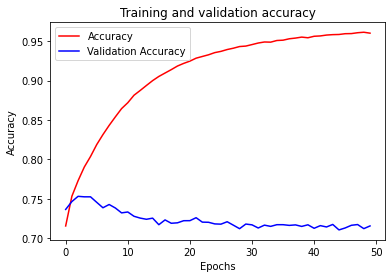

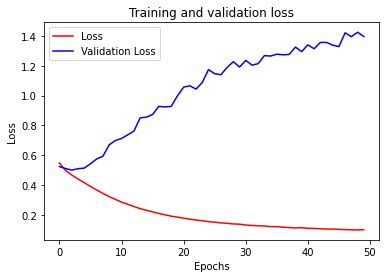

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!